<a href="https://colab.research.google.com/github/divassya/CS767_ML_project/blob/main/CS767_animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [17]:
# base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
from tqdm import tqdm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
# need to create new API token (the file kaggle.json) of Kaggle account and locate it in the same folder as the code
from kaggle.api.kaggle_api_extended import KaggleApi

# for the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16

### Initialize the parameters

In [18]:
seed = 96
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)                      
random.seed(seed)

In [19]:
# initialize the parameters
image_size = (128, 128)
batch_size = 32
val_split = 0.2
# set the path of the data
train_path = './train'

### Extracting data

We use Kaggle API to download the dataset from Kaggle.

In [20]:
# ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [21]:
# initialise the API
kag = KaggleApi()
kag.authenticate()

# downloading the files
kag.competition_download_files(competition='dogs-vs-cats', path='./')

# unzip the files
with ZipFile('dogs-vs-cats.zip', 'r') as z:
    z.extractall()
with ZipFile('train.zip', 'r') as z:
    z.extractall()

In [22]:
# dataframe of labels
df = pd.DataFrame({'image_name':os.listdir(train_path)})
df['label'] =df['image_name'].apply(lambda x: x.split('.')[0])
df.head()

,image_name,label
0,cat.11732.jpg,cat
1,dog.12334.jpg,dog
2,dog.11577.jpg,dog
3,cat.2464.jpg,cat
4,cat.2294.jpg,cat


### Print some images from dataset

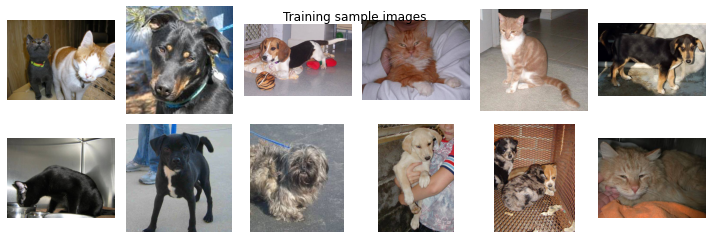

In [23]:
fig = plt.figure(1, figsize = (10, 10))
fig.suptitle("Training sample images ")

for i in range(12):

    plt.subplot(6, 6, i + 1)
    image = load_img(train_path + '/'+ df["image_name"][i])
    plt.imshow(image)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

### Splitting the data

* train_data
* validation_data
* test_data

In [24]:
train_val_data, test_data = train_test_split(df, 
                                        test_size = 0.2, 
                                        stratify = df["label"], 
                                        random_state = seed)
nb_test_samples = test_data.shape[0]
print(train_val_data.shape[0], nb_test_samples)
print(f'Size of test set: {nb_test_samples}')

20000 5000
Size of test set: 5000


In [25]:
train_data, val_data = train_test_split(train_val_data, 
                                        test_size = 0.2, 
                                        stratify = train_val_data["label"], 
                                        random_state = seed)

print(f'Size of train set: {train_data.shape[0]}\nSize of validation set: {val_data.shape[0]} values')

Size of train set: 16000
Size of validation set: 4000 values


### Data Augmentation

In [26]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [27]:
train_generator = training_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = train_path,
    x_col = "image_name",
    y_col = "label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=seed)

Found 16000 validated image filenames belonging to 2 classes.


In [28]:
val_generator = validation_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = train_path,
    x_col = "image_name",
    y_col = "label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=seed)

Found 4000 validated image filenames belonging to 2 classes.


In [29]:
test_generator = validation_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = train_path,
    x_col = "image_name",
    y_col = "label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=seed)

Found 5000 validated image filenames belonging to 2 classes.
